In [1]:
from __future__ import division
import os, pickle, sys, time
import itertools

%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8.0, 10.0)

import cv2
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('jpg')
from PIL import Image, ImageDraw

import torch
import torch.nn as nn

from math import ceil, floor
from skimage import io

In [2]:
# data and annotation directories
dataDir='/data' ##### MAKE SURE THIS IS CORRECT!!!!
# dataType='val2014'
dataType='train2014'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [3]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=12.27s)
creating index...
index created!


In [4]:
# COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds()) # categories
nms=[cat['name'] for cat in cats] # category names
cat_id_to_name = {cat['id']: cat['name'] for cat in cats} # category id to name mapping
cat_name_to_id = {cat['name']: cat['id'] for cat in cats} # category name to id mapping
# print('COCO categories: \n{}'.format(' '.join(nms)))
# print len(nms), '\n'

nms = set([cat['supercategory'] for cat in cats]) # supercategory names
cat_to_supercat = {cat['name']: cat['supercategory'] for cat in cats}
cat_id_to_supercat = {cat['id']: cat['supercategory'] for cat in cats}
# print('COCO supercategories: \n{}'.format(' '.join(nms)))
# print len(nms)

In [5]:
# print supercategory and categories in each supercategory
supercat_to_cats = {}
for key, group in itertools.groupby(sorted([(sc, c) for (c, sc) in cat_to_supercat.items()]), lambda x: x[0]):
    lst = [thing[1] for thing in group]
#     print key, ":", ", ".join(lst)
    supercat_to_cats[key] = lst

# Outline:
This tutorial contains the following sections:
- Visualizing objects in an image
- Region proposals with selective search
- Projecting bounding boxes to feature space
- Extracting features for a bounding box

#### Feature extraction:
Given a bounding box and an image, we extract features 
corresponding to the bounding box in a two-step procedure.
The first step is to "project" the bounding box onto the feature space.
The second step to use the Featurizer module to extract features corresponding to this projected bounding box.

## View objects in an image

In [6]:
colors = [(30,144,255), (255, 140, 0), (34,139,34), (255,0,0), (147,112,219), (139,69,19), (255,20,147), (128,128,128),
         (85,107,47), (0,255,255)]
def get_color(i):
    return colors[i % len(colors)]

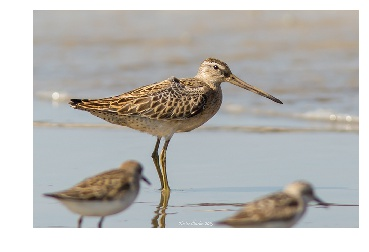

In [7]:
# load and see image
img = coco.loadImgs([123055])[0] # make sure image ID exists in the dataset given to you.
img_pil = Image.open('%s/%s_2/%s'%(dataDir, dataType, img['file_name'])) # make sure data dir is correct

plt.axis('off')
plt.imshow(img_pil)
plt.show()

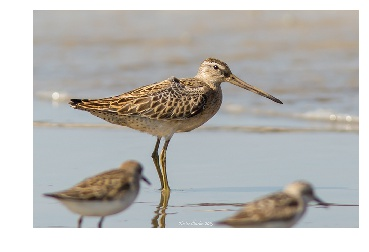

In [8]:
I = io.imread('%s/%s_2/%s'%(dataDir,dataType,img['file_name'])) # make sure data dir is correct
plt.axis('off')
plt.imshow(I)
plt.show()

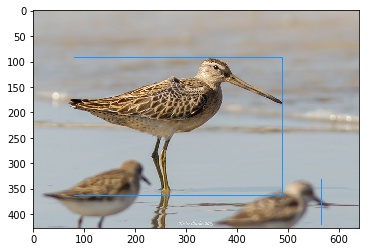

In [9]:
# view objects
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)

categories = {j:i for (i,j) in dict(enumerate(set([ann['category_id'] for ann in anns]))).items()}

img_pil = Image.open('%s/%s_2/%s'%(dataDir, dataType, img['file_name'])) # make sure data dir is correct
draw = ImageDraw.Draw(img_pil)

true_bboxes = []
for ann in anns:
    x, y, w, h = ann['bbox']
    true_bboxes += [ann['bbox']]
    cat_color_id = categories[ann['category_id']] # to give each category a different color
    draw.rectangle(((x, y, x+w, y+h)), fill=None, outline=get_color(cat_color_id)) #RGB
plt.imshow(img_pil);

## Region proposals with Selective Search

### IMPORTANT NOTE:
Note that selective search should be run with images read via OpenCV. Note that OpenCV's selective search has a bug: place your code in a try-catch block (see example below) and ignore images that throw errors.

In [10]:
# selective search tutorial: https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/
cv2.setNumThreads(4)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
num_rects = 1000

def get_bboxes(img, ss, num_rects=2000):
    try:
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchQuality() # good quality search
        # ss.switchToSelectiveSearchFast() # fast search
        t1 = time.time()
        rects = ss.process()
        t1 = time.time() - t1
        return rects[:num_rects]
    except KeyboardInterrupt:
        print('keyboard interrupt')
        sys.exit()    
    except:
        return None

In [11]:
# run selective search on the image
img_cv = cv2.imread('%s/%s/%s'%(dataDir,dataType,img['file_name'])) 
num_rects = 2000
bboxes = get_bboxes(img_cv, ss, num_rects=num_rects)
if bboxes is None: ### OpenCV has thrown an error. Discard image.
    print('discard image from consideration.')

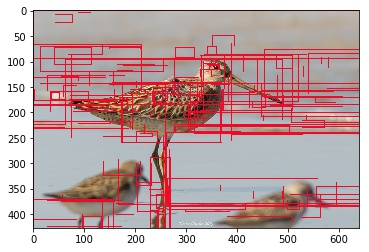

In [12]:
# visualize outputs of selective search 
img_pil = Image.open('%s/%s_2/%s'%(dataDir, dataType, img['file_name'])) # make sure data dir is correct
draw = ImageDraw.Draw(img_pil)
for it in range(200):
    idx = np.random.randint(0, num_rects)
    x, y, w, h = bboxes[idx]
    draw.rectangle(((x, y, x+w, y+h)), fill=None, outline=(240, 10, 40)) #RGB
plt.imshow(img_pil);

## Code to compute IoU (intersection over union)

In [13]:
# IoU
def iou(rect1, rect2): # rect = [x, y, w, h]
    x1, y1, w1, h1 = rect1
    X1, Y1 = x1+w1, y1 + h1
    x2, y2, w2, h2 = rect2
    X2, Y2 = x2+w2, y2 + h2
    a1 = (X1 - x1 + 1) * (Y1 - y1 + 1)
    a2 = (X2 - x2 + 1) * (Y2 - y2 + 1)
    x_int = max(x1, x2) 
    X_int = min(X1, X2) 
    y_int = max(y1, y2) 
    Y_int = min(Y1, Y2) 
    a_int = (X_int - x_int + 1) * (Y_int - y_int + 1) * 1.0 
    if x_int > X_int or y_int > Y_int:
        a_int = 0.0 
    return a_int / (a1 + a2 - a_int)  

In [14]:
# Compute IoU of output of selective search with the true bounding box.
# If IoU > 0.5, the bounding box from selective search is said to contain the object
true_rect = true_bboxes[1] # the biggest object in the foreground for this example.
ious = np.asarray([iou(true_rect, r) for r in bboxes])
print('largest iou:', ious.max())
print('# ious > 0.5:', (ious > 0.5).sum(), 'out of', len(ious))

largest iou: 0.9378887247092724
# ious > 0.5: 58 out of 2000


## Project bounding box in original image coordinates to projected_coordinates

In [15]:
# nearest neighbor in 1-based indexing
def _nnb_1(x):                                                                                                                               
    x1 = int(floor((x + 8) / 16.0))
    x1 = max(1, min(x1, 13))
    return x1


def project_onto_feature_space(rect, image_dims):
    # project bounding box onto conv net
    # @param rect: (x, y, w, h)
    # @param image_dims: (imgx, imgy), the size of the image
    # output bbox: (x, y, x'+1, y'+1) where the box is x:x', y:y'

    # For conv 5, center of receptive field of i is i_0 = 16 i for 1-based indexing
    imgx, imgy = image_dims
    x, y, w, h = rect
    # scale to 224 x 224, standard input size.
    x1, y1 = ceil((x + w) * 224 / imgx), ceil((y + h) * 224 / imgy)
    x, y = floor(x * 224 / imgx), floor(y * 224 / imgy)
    px = _nnb_1(x + 1) - 1 # inclusive
    py = _nnb_1(y + 1) - 1 # inclusive
    px1 = _nnb_1(x1 + 1) # exclusive
    py1 = _nnb_1(y1 + 1) # exclusive

    return [px, py, px1, py1]

In [16]:
# example: projected bounding box dimensions 
idx = ious.argmax()
projected_bbox = project_onto_feature_space(bboxes[idx], img_pil.size)
print('projected_bbox:', projected_bbox)

projected_bbox: [0, 9, 5, 13]


### Extract features from bounding boxes
The code below works for both the tiny features and the small features

In [17]:
class Featurizer:
    dim = 11776 # for small features
    def __init__(self):
        # pyramidal pooling of sizes 1, 3, 6
        self.pool1 = nn.AdaptiveMaxPool2d(1)
        self.pool3 = nn.AdaptiveMaxPool2d(3)                                                                                                 
        self.pool6 = nn.AdaptiveMaxPool2d(6)
        self.lst = [self.pool1, self.pool3, self.pool6]
        
    def featurize(self, projected_bbox, image_features):
        # projected_bbox: bbox projected onto final layer
        # image_features: C x W x H tensor : output of conv net
        full_image_features = torch.from_numpy(image_features)
        x, y, x1, y1 = projected_bbox
        crop = full_image_features[:, x:x1, y:y1] 
#         return torch.cat([self.pool1(crop).view(-1), self.pool3(crop).view(-1),  
#                           self.pool6(crop).view(-1)], dim=0) # returns torch Variable
        return torch.cat([self.pool1(crop).view(-1), self.pool3(crop).view(-1),  
                          self.pool6(crop).view(-1)], dim=0).data.numpy() # returns numpy array


In [18]:
# read features:
with open('{}/features2_tiny/{}.p'.format(dataDir, dataType), 'rb') as f:
    img_ids, feats = pickle.load(f, encoding='bytes')
featurizer = Featurizer()

In [19]:
idx = img_ids.index(123055)
img_feats = feats[idx]

bbox_feats = featurizer.featurize(projected_bbox, img_feats) 
print('bbox_feats.shape:', bbox_feats.shape)

bbox_feats.shape: (1472,)


In [20]:
# read bboxes:
with open('{}/bboxes/{}_bboxes.p'.format(dataDir, dataType), 'rb') as f:
    img_ids_bboxes, bbox_labels = pickle.load(f, encoding='bytes')

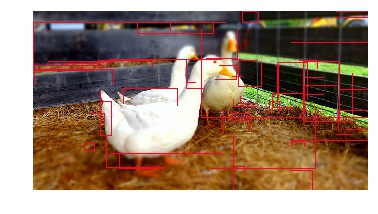

In [21]:
BBOX_IMG_ID = 16

img_bbox = coco.loadImgs([img_ids_bboxes[BBOX_IMG_ID ]])[0]
img_bbox_pil = Image.open('%s/%s_2/%s'%(dataDir, dataType, img_bbox['file_name'])) # make sure data dir is correct
draw = ImageDraw.Draw(img_bbox_pil)
for it in range(64):
    idx = np.random.randint(0, len(bbox_labels[BBOX_IMG_ID]))
    x, y, w, h = bbox_labels[BBOX_IMG_ID][idx]
    draw.rectangle(((x, y, x+w, y+h)), fill=None, outline=(240, 10, 40)) #RGB

plt.axis('off')
plt.imshow(img_bbox_pil)
plt.show();